In [1]:
import numpy as np
import os
from itertools import product
from pathlib import Path
import sys
sys.path.append('..')

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

In [2]:
data_path = os.path.join(Path(os.getcwd()).parent.absolute(), 'data')

accuracy_matrix = np.load(os.path.join(data_path, 'acc_matrix_res64_all.npy'))
memory_matrix = np.load(os.path.join(data_path, 'mem_matrix_full.npy'))
error_matrix = 1 - accuracy_matrix

idx_dataset_to_remove = 28 # remove full CIFAR100
memory_matrix = np.delete(memory_matrix, idx_dataset_to_remove, axis=0)
error_matrix = np.delete(error_matrix, idx_dataset_to_remove, axis=0)

In [3]:
# Very slow for many datapoints.  Fastest for many costs, most readable
def is_pareto_efficient_dumb(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

In [4]:
# low precision configurations
low_formats = [['Representation_Float', '5', 1],['Representation_Float', '6', 2],
               ['Representation_Float', '7', 3],['Representation_Float', '8', 4],
               ['Representation_Float', '6', 1],['Representation_Float', '7', 2],
               ['Representation_Float', '8', 3],['Representation_Float', '9', 4],
               ['Representation_Float', '7', 1],['Representation_Float', '8', 2],
               ['Representation_Float', '9', 3]]

high_formats = [['Representation_Float', '14', 7],['Representation_Float', '16', 9],
                ['Representation_Float', '18', 11],['Representation_Float', '15', 7],
                ['Representation_Float', '17', 9],['Representation_Float', '19', 11],
                ['Representation_Float', '16', 7],['Representation_Float', '18', 9],
                ['Representation_Float', '20', 11]]

lp_configs = np.array(list(product(low_formats, high_formats)))

In [5]:
memory_matrix_flattened = memory_matrix.flatten()
error_matrix_flattened = error_matrix.flatten()

([<matplotlib.axis.YTick at 0x7f844be607f0>,
 <a list of 5 Text yticklabel objects>)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


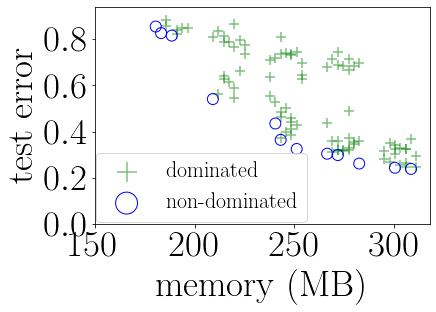

In [6]:
costs = np.hstack((memory_matrix[0].reshape(-1, 1), error_matrix[0].reshape(-1, 1)))
is_efficient = is_pareto_efficient_dumb(costs)
indices_true_frontier = np.where(is_efficient)[0]
indices_not_frontier = np.array(list(set(np.arange(costs.shape[0])).difference(set(indices_true_frontier))))

memory_single_eff = memory_matrix[0][indices_true_frontier]
error_single_eff = error_matrix[0][indices_true_frontier]
memory_single_non_eff = memory_matrix[0][indices_not_frontier]
error_single_non_eff = error_matrix[0][indices_not_frontier]

# change color

fontsize = 37

plt.scatter(memory_single_non_eff, error_single_non_eff, color='green', s=100, marker='+', alpha=.5, label='dominated')
plt.scatter(memory_single_eff, error_single_eff, s=120, facecolors='None', edgecolors='blue', label='non-dominated')
plt.xlabel("memory (MB)", fontsize=fontsize)
plt.ylabel("test error", fontsize=fontsize)
xtick_pos = [150, 200, 250, 300]
ytick_pos = [0, 0.2, 0.4, 0.6, 0.8]
plt.legend(loc='lower left', bbox_to_anchor=(-0.03, -0.04), fontsize=fontsize-15, markerscale=2)
plt.xticks(xtick_pos, fontsize=fontsize)
plt.yticks(ytick_pos, fontsize=fontsize)

In [7]:
# get the Pareto optimal configuration details on all datasets
low_formats_bits_all = []
high_formats_bits_all = []
low_formats_man_all = []
high_formats_man_all = []

for i in range(error_matrix.shape[0]):    
    costs = np.hstack((memory_matrix[i].reshape(-1, 1), error_matrix[i].reshape(-1, 1)))
    is_efficient = is_pareto_efficient_dumb(costs)
    indices_true_frontier = np.where(is_efficient)[0]
    lp_configs_pf = lp_configs[indices_true_frontier]
    for lp_configs_pf_single in lp_configs_pf:
        
        low_formats_bits_all.append(eval(lp_configs_pf_single[0][1]))
        low_formats_man_all.append(eval(lp_configs_pf_single[0][2]))
        high_formats_bits_all.append(eval(lp_configs_pf_single[1][1]))
        high_formats_man_all.append(eval(lp_configs_pf_single[1][2]))


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


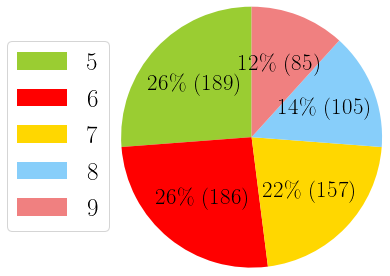

In [8]:
# Pie chart for activation bits

unique, counts = np.unique(low_formats_bits_all, return_counts=True)

colors = ['yellowgreen', 'red', 'gold', 'lightskyblue','lightcoral', 'blue', 'pink', 'darkgreen', 'violet']

patches, texts, autotexts =plt.pie(counts, colors=colors, shadow=False, 
                                   autopct=lambda s: '{p:.0f}\% ({v:d})'.format(p=s, v=int(np.sum(counts) * s/100)), 
                                   startangle=90, radius=1.5)

labels = ['{}'.format(i) for i in unique]

plt.setp(autotexts, size=23, weight="bold")

sort_legend = False
if sort_legend:
    patches, labels, dummy = zip(*sorted(zip(patches, labels, counts),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=25)